In [1]:
import cveig
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import binom
import pickle
from tqdm.autonotebook import tqdm
import seaborn as sns

<ipython-input-1-bf68ba4e83d5>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
k = 10
n_tries = 10
expected_degrees = np.arange(25, 61, 5)
thetas = ['point', 'exp', 'pareto']

In [3]:
results = np.empty((n_tries, len(expected_degrees), len(thetas), 5))

for d, degree in enumerate(tqdm(expected_degrees)):
    for i in tqdm(range(n_tries)):
        for j, theta in enumerate(thetas):
            file = f'../../masters_r/samples/graph_{theta}_{degree}_{i+1}.table'
            # print(file)
            adj_matrix = pd.read_table(file, sep=' ').to_numpy()
                
            adj_matrix = sparse.csr_array(adj_matrix)

            results[i, d, j, 0] = cveig.eig_cv(adj_matrix, 15, 0.05)
            results[i, d, j, 1] = cveig.eig_cv(adj_matrix, 15, 0.1)
            results[i, d, j, 2] = cveig.eig_cv(adj_matrix, 15, 0.3)
            results[i, d, j, 3] = cveig.eig_cv(adj_matrix, 15, 0.5)
            results[i, d, j, 4] = cveig.eig_cv(adj_matrix, 15, 0.8)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
with open('results_split2.pickle', 'wb') as f:
    pickle.dump(results, f)

In [5]:
with open('results_split2.pickle', 'rb') as f:
    results = pickle.load(f)

In [6]:
k = 10
n_tries = 10
expected_degrees = np.arange(25, 61, 5)
thetas = ['point', 'exp', 'pareto']
results_comp = np.empty((n_tries, len(expected_degrees), len(thetas), 3))

for d, degree in enumerate(tqdm(expected_degrees)):
    for i in tqdm(range(n_tries)):
        for j, theta in enumerate(thetas):
            file = f'../../masters_r/samples/graph_{theta}_{degree}_{i+1}.table'
            # print(file)
            adj_matrix = pd.read_table(file, sep=' ').to_numpy()
                
            adj_matrix = sparse.csr_array(adj_matrix)

            results_comp[i, d, j, 0] = cveig.non_backtracking(adj_matrix, 15)
            results_comp[i, d, j, 1] = cveig.bethe_hessian(adj_matrix)
            results_comp[i, d, j, 2] = cveig.eig_cv(adj_matrix, 15, 0.1)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eigs did not converge. Computed 11 eigenvectors


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eigs did not converge. Computed 14 eigenvectors


In [7]:
with open('results_comp2.pickle', 'wb') as f:
    pickle.dump(results_comp, f)

In [8]:
with open('results_comp2.pickle', 'rb') as f:
    results_comp = pickle.load(f)

In [9]:
names_split = ['sample', 'degree', 'theta', 'prob']
names_comp = ['sample', 'degree', 'theta', 'algorithm']
thetas = ['point', 'exp', 'pareto']
probs = [0.05, 0.1, 0.3, 0.5, 0.8]
algs = ['Non-backtracking', 'Bethe-Hessian', 'CV Eigenvalues']
labels_split = [np.arange(n_tries), expected_degrees, thetas, probs]
labels_comp = [np.arange(n_tries), expected_degrees, thetas, algs]

In [10]:
index_split = pd.MultiIndex.from_product(labels_split, names=names_split)
result_df_split = pd.DataFrame(results.reshape(-1, 1),index=index_split)
result_df_split.columns = ['value']

index_comp = pd.MultiIndex.from_product(labels_comp, names=names_comp)
result_df_comp = pd.DataFrame(results_comp.reshape(-1, 1),index=index_comp)
result_df_comp.columns = ['value']

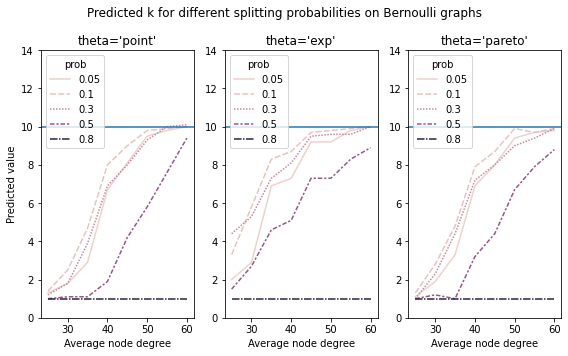

In [11]:
fig, ax = plt.subplots(1,3, figsize=(8,5))
degrees = []
for j, theta in enumerate(thetas):
    # ax[i, j].set_title(theta)
    sns.lineplot(
        x="degree", 
        y="value", 
        ci=None, 
        data=result_df_split.loc[:, :, theta, :], 
        ax=ax[j],
        hue='prob',
        style='prob',
        )
    ax[j].set_ylim(0, 14)
    ax[j].set_title(f'{theta=}')
    ax[j].axhline(10)
    ax[j].set_xlabel('Average node degree')
    ax[j].set_ylabel('Predicted value')
    if j>0: ax[j].set_ylabel(None)



#ax[0].set_ylabel('Average error')
#ax[1].set_xlabel('Expected vertex degree')
#handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', title='Number of folds')
fig.suptitle('Predicted k for different splitting probabilities on Bernoulli graphs')
fig.tight_layout()
fig.savefig('test_prob.png')

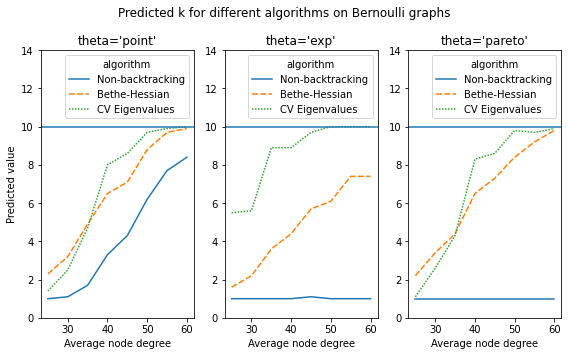

In [12]:
fig, ax = plt.subplots(1,3, figsize=(8,5))
degrees = []
for j, theta in enumerate(thetas):
    # ax[i, j].set_title(theta)
    sns.lineplot(
        x="degree", 
        y="value", 
        ci=None, 
        data=result_df_comp.loc[:, :, theta, :], 
        ax=ax[j],
        hue='algorithm',
        style='algorithm',
        )
    ax[j].set_ylim(0, 14)
    ax[j].set_title(f'{theta=}')
    ax[j].axhline(10)
    ax[j].set_xlabel('Average node degree')
    ax[j].set_ylabel('Predicted value')
    if j>0: ax[j].set_ylabel(None)



#ax[0].set_ylabel('Average error')
#ax[1].set_xlabel('Expected vertex degree')
#handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', title='Number of folds')
fig.suptitle('Predicted k for different algorithms on Bernoulli graphs')
fig.tight_layout()
fig.savefig('test_alg.png')